In [1]:
import pandas as pd
import os
import re
import numpy as np
import math

In [2]:
data = pd.read_csv("abnormal_stock_list.csv").drop(['name'], axis=1)
data.head()

,trade_date,stock_code,open,high,low,close,pre_close,change,stock_chg,vol,amount,turnover_rate,volume_ratio,index_chg,gap,label
0,20210315,601818.SH,4.24,4.28,4.20,4.26,4.23,0.03,0.7092,1846221.27,784635.868,0.4465,0.80,-0.9595,1.6687,0
1,20210312,601818.SH,4.10,4.23,4.08,4.23,4.11,0.12,2.9197,3441213.11,1438667.971,0.8322,1.78,0.4727,2.4470,0
2,20210311,601818.SH,4.06,4.14,4.05,4.11,4.03,0.08,1.9851,2198806.38,900407.536,0.5317,1.10,2.3556,-0.3705,0
3,20210310,601818.SH,4.08,4.08,4.03,4.03,4.07,-0.04,-0.9828,1603894.59,649490.314,0.3879,0.69,-0.0463,-0.9365,0
4,20210309,601818.SH,4.14,4.18,4.06,4.07,4.12,-0.05,-1.2136,2210029.10,907762.819,0.5344,0.99,-1.8157,0.6021,0


# Data Preprocess

In [3]:
def getlistnum(li):
    li = list(li)
    set1 = set(li)
    dict1 = {}
    for item in set1:
        dict1.update({item:li.count(item)})
    return dict1

n_data = data

print(getlistnum(n_data['label']))

n_data = n_data.drop(n_data[n_data.isnull().values==True].index)

print(n_data.isnull().any())
print(np.isnan(np.array(n_data).any()))
print(np.isinf(np.array(n_data).all()))

{0: 449061, 1: 24817}
trade_date       False
stock_code       False
open             False
high             False
low              False
close            False
pre_close        False
change           False
stock_chg        False
vol              False
amount           False
turnover_rate    False
volume_ratio     False
index_chg        False
gap              False
label            False
dtype: bool
False
False


# To solve the problem of disproportion of ab/non-ab
1. select same stock  (fail)
    
    {0: 137413, 1: 24388}
    
    mean:0.2
    
2. select same stock and abnormal times > 20

    {0: 22818, 1: 16197} mean:0.4
    
        Logit 0.43496
        SGD 0.54876
        Tree 0.87543
        
3. select same stock and abnormal times > 15

    {0: 31840, 1: 17904} mean:0.35

    \+ random drop label=0 (index%3==0)
    
    {0: 21200, 1: 17904} mean:0.49
    
        Logit 0.45685
        SGD 0.54865
        Tree 0.86281

    times > 10
    
    \+ random drop label=0 (sqrt(index) % 2 ==0)
    
    {0: 28781, 1: 20299} mean:0.41

        Logit 0.40841
        SGD 0.40841
        Tree 0.86705
        
    times > 5
    
    \+ random drop label=0 index % 4 != 0)
    
    {0: 20634, 1: 22598}  mean:0.521787
    
        Logit acc: 0.51810; pre: 0.51810; recall: 0.51810; F-1: 0.35363; Kappa: 0.00000;
        Sgd acc: 0.55129; pre: 0.55129; recall: 0.55129; F-1: 0.47520; Kappa: 0.07730;
        Tree acc: 0.84781; pre: 0.84781; recall: 0.84781; F-1: 0.84773; Kappa: 0.69499;
        
    \+ random drop label=0 index % 3 != 0)

    {0: 27544, 1: 22598}  mean:0.449979

        Logit acc: 0.45348; pre: 0.45348; recall: 0.45348; F-1: 0.28297; Kappa: 0.00000;
        SGD acc: 0.45269; pre: 0.45269; recall: 0.45269; F-1: 0.28263; Kappa: -0.00160;
        Tree acc: 0.85093; pre: 0.85093; recall: 0.85093; F-1: 0.85091; Kappa: 0.69919;

In [4]:
ab_code_list = []
ab_code_times = {}
for index, row in n_data.iterrows():
    if row['label']==1:
        if row['stock_code'] in ab_code_times.keys():
            ab_code_times[row['stock_code']] = ab_code_times[row['stock_code']]+1
        else:
            ab_code_times.update({row['stock_code']:1})
        
        if row['stock_code'] in ab_code_list:
            continue
        else:
            ab_code_list.append(row['stock_code'])
print(len(ab_code_list))

1451


In [5]:
input_data = []
GROUP_NUM = 5
group_num = 0
for index, row in n_data.iterrows():
    if row['stock_code'] in ab_code_list:
        if ab_code_times[row['stock_code']] > 5:
            row['group'] = group_num
            if group_num == GROUP_NUM:
                group_num = 0
            group_num = group_num + 1
            input_data.append(row)

i_data = pd.DataFrame(input_data)

print(getlistnum(i_data['label']))
print(len(i_data))

{0: 82565, 1: 22598}
105163


In [6]:
# random drop
drop_list = []
for index, row in i_data.iterrows():
    if row['label'] == 0:
        # toe = int(math.sqrt(index)) % 2
        toe = index % 3
        if toe != 0:
            drop_list.append(index)
new_data = i_data.drop(index = drop_list)
print(getlistnum(new_data['label']))
print(len(new_data))

{0: 27544, 1: 22598}
50142


In [8]:
new_data.to_csv("ab_data_ed.csv")

In [3]:
def getlistnum(li):
    li = list(li)
    set1 = set(li)
    dict1 = {}
    for item in set1:
        dict1.update({item:li.count(item)})
    return dict1

new_data = pd.read_csv("ab_data_ed.csv", index_col=0)
print(getlistnum(new_data['label']))
print(len(new_data))

{0: 27544, 1: 22598}
50142


In [4]:
n_rows = len(new_data)
train_len = int(math.floor(0.80*n_rows))
validation_len = int(n_rows - train_len)

data_input = new_data.reindex(np.random.permutation(new_data.index))

training_input = data_input.head(train_len)
validation_input = data_input.tail(validation_len)

In [5]:
training_targets = training_input[["label"]]
training_examples = training_input.drop(["label","trade_date", "stock_code", "group"], axis=1)

validation_targets = validation_input[["label"]]
validation_examples = validation_input.drop(["label","trade_date", "stock_code", "group"], axis=1)

from IPython import display

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,close,pre_close,change,stock_chg,vol,amount,turnover_rate,volume_ratio,index_chg,gap
count,40113.000000,40113.000000,40113.000000,40113.000000,40113.000000,40113.000000,40113.000000,4.011300e+04,4.011300e+04,40113.000000,40113.000000,40113.000000,40113.000000
mean,16.811844,17.326317,16.382865,16.858275,16.839196,0.019079,0.259090,2.964833e+05,3.006291e+05,5.794343,1.219899,0.031585,0.227505
std,26.060781,26.904693,25.311480,26.102889,26.120959,1.439104,4.258529,7.128701e+05,6.089302e+05,6.814260,2.552607,1.315023,4.246427
min,0.210000,0.220000,0.200000,0.200000,0.220000,-58.610000,-20.073000,1.000000e+01,5.000000e-01,0.000100,0.000000,-4.983600,-23.843900
25%,4.850000,4.980000,4.740000,4.860000,4.860000,-0.190000,-2.139000,3.589329e+04,3.576563e+04,1.437300,0.710000,-0.676400,-2.103700
50%,9.310000,9.590000,9.100000,9.340000,9.310000,0.000000,0.000000,1.011303e+05,1.041340e+05,3.597500,0.940000,0.018200,-0.221800
75%,18.430000,18.970000,18.010000,18.500000,18.460000,0.200000,2.213500,3.117700e+05,2.986544e+05,7.795200,1.310000,0.860600,2.148100
max,621.900000,637.670000,621.900000,636.270000,622.900000,27.870000,20.120100,3.607391e+07,1.185186e+07,75.831000,263.730000,3.907800,24.983600


Validation examples summary:


,open,high,low,close,pre_close,change,stock_chg,vol,amount,turnover_rate,volume_ratio,index_chg,gap
count,10029.000000,10029.000000,10029.000000,10029.000000,10029.00000,10029.000000,10029.000000,1.002900e+04,1.002900e+04,10029.000000,10029.000000,10029.000000,10029.000000
mean,17.092022,17.604400,16.640730,17.129275,17.12110,0.008175,0.247396,3.000487e+05,3.093647e+05,5.897091,1.249290,0.016259,0.231137
std,27.404565,28.178252,26.485704,27.327424,27.47597,1.517771,4.222524,7.057400e+05,6.256199e+05,7.144263,2.704522,1.332548,4.204310
min,0.240000,0.240000,0.240000,0.240000,0.27000,-36.720000,-20.091300,5.400000e+02,4.381410e+02,0.006500,0.020000,-4.983600,-20.736700
25%,4.950000,5.080000,4.810000,4.930000,4.94000,-0.200000,-2.156100,3.617271e+04,3.520547e+04,1.435700,0.710000,-0.709600,-2.073300
50%,9.550000,9.820000,9.310000,9.570000,9.56000,0.000000,0.000000,1.032470e+05,1.048725e+05,3.549400,0.940000,0.013300,-0.205100
75%,18.430000,18.980000,17.900000,18.490000,18.50000,0.190000,2.241400,3.039183e+05,3.033621e+05,7.710200,1.310000,0.860600,2.150500
max,630.360000,630.860000,614.310000,619.000000,626.80000,22.000000,20.026200,2.898865e+07,1.179899e+07,75.950600,124.640000,3.907800,23.315900


Training targets summary:


,label
count,40113.000000
mean,0.451948
std,0.497692
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Validation targets summary:


,label
count,10029.000000
mean,0.445608
std,0.497057
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# PCA?
Weather use?
# NOT USE

In [12]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=3)
training_examples = pca.fit_transform(training_examples)
print(pca.explained_variance_ratio_)

[8.13768586e-01 1.86231410e-01 3.73600066e-09]


GBDT

|FUNCTION|Acc|Pre|Recall|F-1|Kappa|
|--------|---|---|------|---|-----|
|USE n=5 | 0.87097 (+/- 0.00392)| 0.86439 | 0.86439 | 0.86439 | 0.86405 | 0.72483 |
|USE n=3 | 0.72726 (+/- 0.00212)| 0.70625 | 0.70625 | 0.70625 | 0.70340 | 0.39921 |
|NO USE | 0.88714 (+/- 0.00200)| 0.88214 | 0.88214 | 0.88214 | 0.88208 | 0.76160 |

# Machine Learning
validate: GroupShuffleSplit

Ans

|FUNCTION|Acc|Pre|Recall|F-1|Kappa|
|--------|---|---|------|---|-----|
|Logit | 0.52327 (+/- 0.00104) | 0.51810 | 0.51810 | 0.51810 | 0.35363 | 0.00000;
|SGD | 0.51661 (+/- 0.06175)| 0.55129 | 0.55129 | 0.55129 | 0.47520 | 0.07730;
|Decision Tree | 0.84578 (+/- 0.00586)| 0.84781 | 0.84781 | 0.84781 | 0.84773 | 0.69499;
|GBDT | 0.88741 (+/- 0.00412)| 0.88632 | 0.88632 | 0.88632 | 0.88635 | 0.77249 |

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn import svm, tree
import warnings
warnings.filterwarnings("ignore")

In [39]:
gss = GroupShuffleSplit(n_splits=GROUP_NUM, test_size=0.3, random_state=0)
ss = ShuffleSplit(n_splits=GROUP_NUM, test_size=0.2, random_state=0)
groups = training_input['group'].values

logi_clf = LogisticRegression(solver="lbfgs", C=0.05, penalty="l2").fit(training_examples, training_targets.values)
sgd_clf = SGDClassifier(loss="log", max_iter=10000, alpha=0.01,
                        learning_rate="optimal").fit(training_examples, training_targets.values)
tree_clf = tree.DecisionTreeClassifier().fit(training_examples, training_targets.values)

logit_scores = cross_val_score(logi_clf, training_examples,
                               training_targets.values,
                               cv=gss,groups=groups)

sgd_scores = cross_val_score(sgd_clf, training_examples,
                             training_targets.values,
                             cv=gss,groups=groups)

tree_scores = cross_val_score(tree_clf, training_examples,
                             training_targets.values,
                             cv=gss,groups=groups)

print("Logit Accuracy: %0.5f (+/- %0.5f)" % (logit_scores.mean(), logit_scores.std() * 2 ))
print("SGD Accuracy: %0.5f (+/- %0.5f)" % (sgd_scores.mean(), sgd_scores.std() * 2))
print("Decision Tree Accuracy: %0.5f (+/- %0.5f)" % (tree_scores.mean(), tree_scores.std() * 2))

(40113, 13)
Logit Accuracy: 0.45113 (+/- 0.00286)
SGD Accuracy: 0.54700 (+/- 0.12977)
Decision Tree Accuracy: 0.84901 (+/- 0.00133)


In [35]:
from sklearn import metrics

logi_validation_ans = logi_clf.predict(validation_examples)
sgd_validation_ans = sgd_clf.predict(validation_examples)
tree_validation_ans = tree_clf.predict(validation_examples)

print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, logi_validation_ans),
       metrics.precision_score(validation_targets, logi_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, logi_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, logi_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, logi_validation_ans)
      ))

print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, sgd_validation_ans,),
       metrics.precision_score(validation_targets, sgd_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, sgd_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, sgd_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, sgd_validation_ans)
      ))

print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, tree_validation_ans),
       metrics.precision_score(validation_targets, tree_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, tree_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, tree_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, tree_validation_ans)
      ))

| 0.67614 | 0.67614 | 0.67614 | 0.66170 | 0.32358 |
| 0.64872 | 0.64872 | 0.64872 | 0.62821 | 0.26213 |
| 0.60794 | 0.60794 | 0.60794 | 0.60738 | 0.20579 |


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit, ShuffleSplit
import warnings
warnings.filterwarnings("ignore")
GROUP_NUM = 5

In [11]:
gss = GroupShuffleSplit(n_splits=GROUP_NUM, test_size=0.3, random_state=0)
ss = ShuffleSplit(n_splits=GROUP_NUM, test_size=0.3, random_state=0)
groups = training_input['group'].values

# GBDT_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                                  max_depth=1, random_state=0).fit(training_examples, training_targets)

# GBDT_scores = cross_val_score(GBDT_clf, training_examples,
#                              training_targets.values,
#                              cv=gss,groups=groups)

In [50]:
print("GBDT Accuracy: %0.5f (+/- %0.5f)" % (GBDT_scores.mean(), GBDT_scores.std() * 2 ))

GBDT_validation_ans = GBDT_clf.predict(validation_examples)
print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, GBDT_validation_ans),
       metrics.precision_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, GBDT_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, GBDT_validation_ans)
      ))

GBDT Accuracy: 0.88714 (+/- 0.00200)
| 0.88214 | 0.88214 | 0.88214 | 0.88208 | 0.76160 |


# USE pipelines to determine the para of GBDT

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':range(1,50),
              'learning_rate':[0.01,0.03,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
              }
GBDT_clf = GradientBoostingClassifier(max_depth = 5)
clf = GridSearchCV(GBDT_clf, parameters, cv = ss)
clf.fit(training_examples, training_targets)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None),
             estimator=GradientBoostingClassifier(max_depth=5),
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4,
                                           0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'n_estimators': range(1, 50)})

In [15]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.172411,0.020582,0.004096,0.000225,0.01,1,"{'learning_rate': 0.01, 'n_estimators': 1}",0.552352,0.553764,0.542879,0.551853,0.551022,0.550374,0.003852,626
1,0.322727,0.015859,0.004498,0.000583,0.01,2,"{'learning_rate': 0.01, 'n_estimators': 2}",0.552352,0.553764,0.542879,0.551853,0.551022,0.550374,0.003852,626
2,0.461942,0.002565,0.004339,0.000093,0.01,3,"{'learning_rate': 0.01, 'n_estimators': 3}",0.552352,0.553764,0.542879,0.551853,0.551022,0.550374,0.003852,626
3,0.614683,0.009055,0.004709,0.000272,0.01,4,"{'learning_rate': 0.01, 'n_estimators': 4}",0.552352,0.553764,0.542879,0.551853,0.551022,0.550374,0.003852,626
4,0.766758,0.008938,0.004829,0.000088,0.01,5,"{'learning_rate': 0.01, 'n_estimators': 5}",0.552352,0.553764,0.542879,0.551853,0.551022,0.550374,0.003852,626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,7.028975,0.080590,0.013385,0.001130,1,45,"{'learning_rate': 1, 'n_estimators': 45}",0.883912,0.881918,0.884743,0.883081,0.885491,0.883829,0.001250,588
633,7.312431,0.298612,0.013357,0.000182,1,46,"{'learning_rate': 1, 'n_estimators': 46}",0.883912,0.882500,0.886156,0.879840,0.884993,0.883480,0.002184,591
634,7.265014,0.016749,0.012736,0.001016,1,47,"{'learning_rate': 1, 'n_estimators': 47}",0.884162,0.882832,0.882998,0.881669,0.884494,0.883231,0.001011,594
635,7.731073,0.163395,0.012923,0.000390,1,48,"{'learning_rate': 1, 'n_estimators': 48}",0.882832,0.882583,0.884909,0.878428,0.884328,0.882616,0.002271,595


In [32]:
lr_001 = [[],[]]
lr_003 = [[],[]]
lr_005 = [[],[]]
lr_01 = [[],[]]
lr_02 = [[],[]]
lr_03 = [[],[]]
lr_04 = [[],[]]
lr_05 = [[],[]]
lr_06 = [[],[]]
lr_07 = [[],[]]
lr_08 = [[],[]]
lr_09 = [[],[]]
lr_1 = [[],[]]
for index, row in results.iterrows():
    if row['param_learning_rate'] == 0.01:
        lr_001[0].append(row['param_n_estimators'])
        lr_001[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.03:
        lr_003[0].append(row['param_n_estimators'])
        lr_003[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.05:
        lr_005[0].append(row['param_n_estimators'])
        lr_005[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.1:
        lr_01[0].append(row['param_n_estimators'])
        lr_01[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.2:
        lr_02[0].append(row['param_n_estimators'])
        lr_02[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.3:
        lr_03[0].append(row['param_n_estimators'])
        lr_03[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.4:
        lr_04[0].append(row['param_n_estimators'])
        lr_04[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.5:
        lr_05[0].append(row['param_n_estimators'])
        lr_05[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.6:
        lr_06[0].append(row['param_n_estimators'])
        lr_06[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.7:
        lr_07[0].append(row['param_n_estimators'])
        lr_07[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.8:
        lr_08[0].append(row['param_n_estimators'])
        lr_08[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 0.9:
        lr_09[0].append(row['param_n_estimators'])
        lr_09[1].append(row['mean_test_score'])
    if row['param_learning_rate'] == 1:
        lr_1[0].append(row['param_n_estimators'])
        lr_1[1].append(row['mean_test_score'])

In [33]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

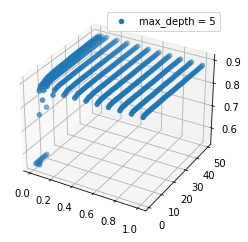

In [34]:
fig = plt.figure()

# 设置三维图形模式
ax = fig.gca(projection='3d')

# 绘制图形
# ax.plot(results['param_learning_rate'].values, 
#         results['param_n_estimators'].values, 
#         results['mean_test_score'].values, label='max_depth = 5')
ax.scatter(results['param_learning_rate'].values, 
        results['param_n_estimators'].values, 
        results['mean_test_score'].values, label='max_depth = 5')

# 显示图例
ax.legend()

# 显示图形
plt.show()

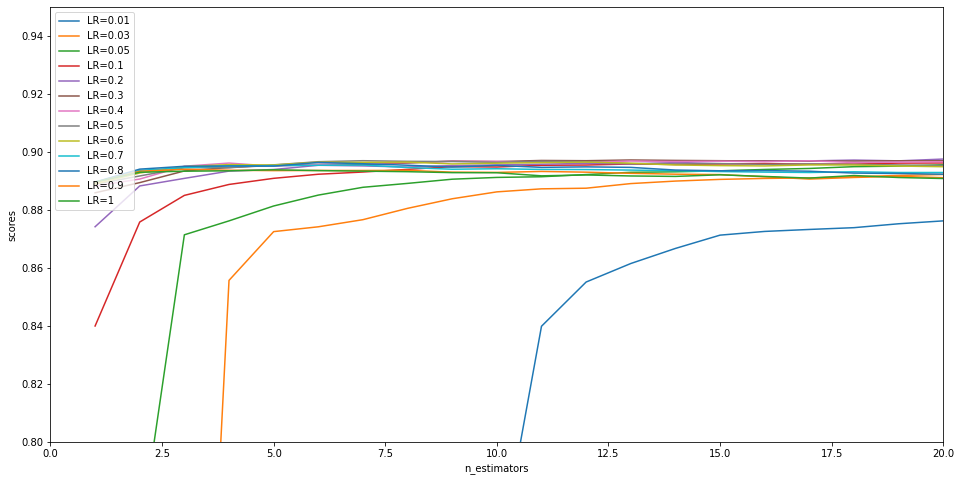

In [41]:

plt.figure(figsize=(16, 8))

plt.plot(lr_001[0], lr_001[1], label="LR=0.01")
plt.plot(lr_003[0], lr_003[1], label="LR=0.03")
plt.plot(lr_005[0], lr_005[1], label="LR=0.05")
plt.plot(lr_01[0], lr_01[1], label="LR=0.1")
plt.plot(lr_02[0], lr_02[1], label="LR=0.2")
plt.plot(lr_03[0], lr_03[1], label="LR=0.3")
plt.plot(lr_04[0], lr_04[1], label="LR=0.4")
plt.plot(lr_05[0], lr_05[1], label="LR=0.5")
plt.plot(lr_06[0], lr_06[1], label="LR=0.6")
plt.plot(lr_07[0], lr_07[1], label="LR=0.7")
plt.plot(lr_08[0], lr_08[1], label="LR=0.8")
plt.plot(lr_09[0], lr_09[1], label="LR=0.9")
plt.plot(lr_1[0], lr_1[1], label="LR=1")

plt.xlim((0, 20))
plt.ylim((0.8,0.95))

plt.xlabel('n_estimators')
plt.ylabel('scores')

plt.legend(loc="upper left")
plt.show()




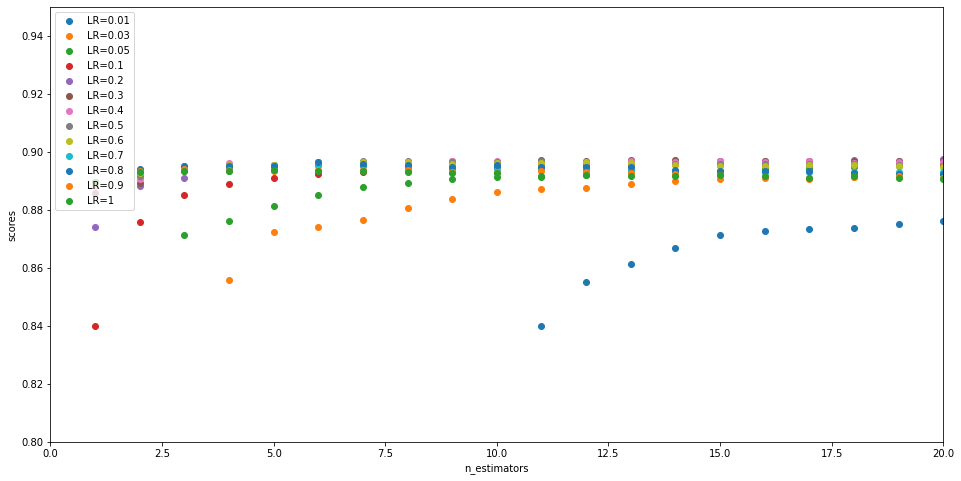

In [42]:
plt.figure(figsize=(16, 8))

plt.scatter(lr_001[0], lr_001[1], label="LR=0.01")
plt.scatter(lr_003[0], lr_003[1], label="LR=0.03")
plt.scatter(lr_005[0], lr_005[1], label="LR=0.05")
plt.scatter(lr_01[0], lr_01[1], label="LR=0.1")
plt.scatter(lr_02[0], lr_02[1], label="LR=0.2")
plt.scatter(lr_03[0], lr_03[1], label="LR=0.3")
plt.scatter(lr_04[0], lr_04[1], label="LR=0.4")
plt.scatter(lr_05[0], lr_05[1], label="LR=0.5")
plt.scatter(lr_06[0], lr_06[1], label="LR=0.6")
plt.scatter(lr_07[0], lr_07[1], label="LR=0.7")
plt.scatter(lr_08[0], lr_08[1], label="LR=0.8")
plt.scatter(lr_09[0], lr_09[1], label="LR=0.9")
plt.scatter(lr_1[0], lr_1[1], label="LR=1")

plt.xlim((0, 20))
plt.ylim((0.8,0.95))

plt.xlabel('n_estimators')
plt.ylabel('scores')

plt.legend(loc="upper left")
plt.show()

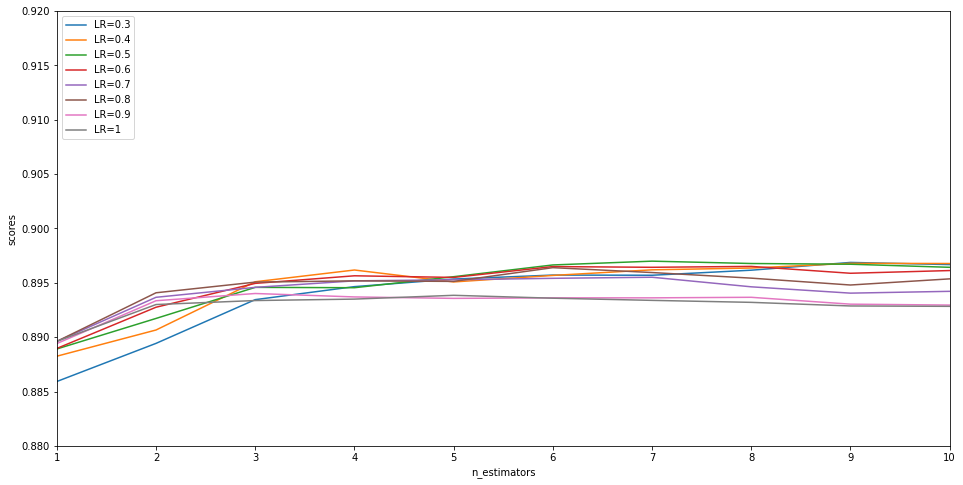

In [44]:
plt.figure(figsize=(16, 8))


plt.plot(lr_03[0], lr_03[1], label="LR=0.3")
plt.plot(lr_04[0], lr_04[1], label="LR=0.4")
plt.plot(lr_05[0], lr_05[1], label="LR=0.5")
plt.plot(lr_06[0], lr_06[1], label="LR=0.6")
plt.plot(lr_07[0], lr_07[1], label="LR=0.7")
plt.plot(lr_08[0], lr_08[1], label="LR=0.8")
plt.plot(lr_09[0], lr_09[1], label="LR=0.9")
plt.plot(lr_1[0], lr_1[1], label="LR=1")

plt.xlim((1, 10))
plt.ylim((0.88,0.92))

plt.xlabel('n_estimators')
plt.ylabel('scores')

plt.legend(loc="upper left")
plt.show()

In [49]:
print(clf.best_params_)
print(clf.refit_time_)

{'learning_rate': 0.1, 'n_estimators': 48}
10.716205358505249


In [89]:
GBDT_clf = GradientBoostingClassifier(n_estimators=15, learning_rate=0.3,
                                 max_depth=5, random_state=0).fit(training_examples, training_targets)
GBDT_scores = cross_val_score(GBDT_clf, training_examples,
                             training_targets.values,
                             cv=gss,groups=groups)
print("GBDT Accuracy: %0.5f (+/- %0.5f)" % (GBDT_scores.mean(), GBDT_scores.std() * 2 ))
GBDT_validation_ans = GBDT_clf.predict(validation_examples)
print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, GBDT_validation_ans),
       metrics.precision_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, GBDT_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, GBDT_validation_ans)
      ))

GBDT Accuracy: 0.89934 (+/- 0.00231)
| 0.89720 | 0.89720 | 0.89720 | 0.89715 | 0.79209 |


In [45]:
GBDT_clf = GradientBoostingClassifier(n_estimators=7, learning_rate=0.5,
                                 max_depth=5, random_state=0).fit(training_examples, training_targets)
GBDT_scores = cross_val_score(GBDT_clf, training_examples,
                             training_targets.values,
                             cv=gss,groups=groups)
print("GBDT Accuracy: %0.5f (+/- %0.5f)" % (GBDT_scores.mean(), GBDT_scores.std() * 2 ))
GBDT_validation_ans = GBDT_clf.predict(validation_examples)
print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, GBDT_validation_ans),
       metrics.precision_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, GBDT_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, GBDT_validation_ans)
      ))

GBDT Accuracy: 0.89799 (+/- 0.00370)
| 0.90009 | 0.90009 | 0.90009 | 0.90003 | 0.79754 |


In [51]:
GBDT_clf = GradientBoostingClassifier(n_estimators=48, learning_rate=0.1,
                                 max_depth=5, random_state=0).fit(training_examples, training_targets)
GBDT_scores = cross_val_score(GBDT_clf, training_examples,
                             training_targets.values,
                             cv=gss,groups=groups)
print("GBDT Accuracy: %0.5f (+/- %0.5f)" % (GBDT_scores.mean(), GBDT_scores.std() * 2 ))
GBDT_validation_ans = GBDT_clf.predict(validation_examples)
print("| %0.5f | %0.5f | %0.5f | %0.5f | %0.5f |" % 
      (metrics.accuracy_score(validation_targets, GBDT_validation_ans),
       metrics.precision_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.recall_score(validation_targets, GBDT_validation_ans, average='micro'),
       metrics.f1_score(validation_targets, GBDT_validation_ans, average='weighted'),
       metrics.cohen_kappa_score(validation_targets, GBDT_validation_ans)
      ))

GBDT Accuracy: 0.90017 (+/- 0.00288)
| 0.90099 | 0.90099 | 0.90099 | 0.90095 | 0.79945 |


In [55]:
import joblib

In [56]:
joblib.dump(GBDT_clf,"AB_Detector_GBDT.model")

['AB_Detector_GBDT.model']

In [62]:
clf = joblib.load("AB_Detector_GBDT.model")
clf.predict(np.array([4.10,4.23,4.08,4.23,4.11,0.12,2.9197,3441213.11,1438667.971,0.8322,1.78,0.4727,2.4470]).reshape(1, -1))

array([0])